In [ ]:
'''
to do
-----
- visualize 33 time series plots all at once, sort by total sales
- build an arima model with highest selling product
- iterate over all products to predict sales individually (find how to dynamically choose pdq)
- sum all predictions to come to total sales
- submit this prediction as intial to gauge RMSLE
- incorporate oil price and holidays

'''

# A. Checking Data

In [7]:
import pandas as pd
import seaborn as sns
import datetime as dt

pd.options.display.float_format = '{:,.2f}'.format
sns.set(rc = {'figure.figsize':(11,8)})

In [2]:
# https://www.kaggle.com/c/store-sales-time-series-forecasting/data

df_train = pd.read_csv('train.csv',sep=',',parse_dates=['date'])
df_test = pd.read_csv('test.csv',sep=',')
df_submission = pd.read_csv('sample_submission.csv',sep=',')
df_stores = pd.read_csv('stores.csv',sep=',')
df_oil = pd.read_csv('oil.csv',sep=',',parse_dates=['date'])
df_holidays_events = pd.read_csv('holidays_events.csv',sep=',',parse_dates=['date'])

In [18]:
df_train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0.0
1,1,2013-01-01,1,BABY CARE,0.0,0.0
2,2,2013-01-01,1,BEAUTY,0.0,0.0
3,3,2013-01-01,1,BEVERAGES,0.0,0.0
4,4,2013-01-01,1,BOOKS,0.0,0.0


In [17]:
df_test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,20.0
1,3000889,2017-08-16,1,BABY CARE,1.0
2,3000890,2017-08-16,1,BEAUTY,8.0
3,3000891,2017-08-16,1,BEVERAGES,560.0
4,3000892,2017-08-16,1,BOOKS,1.0


In [16]:
df_submission.head()

,id,sales
0,3000888,0.0
1,3000889,0.0
2,3000890,0.0
3,3000891,0.0
4,3000892,0.0


In [15]:
df_stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [19]:
df_oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [20]:
df_holidays_events.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


# B. Visaulizing Sales

## (1) Aggregate Level

In [5]:
df_daily_sales = (df_train.groupby(by='date').sum().drop(columns=['id','store_nbr','onpromotion']))

<AxesSubplot:xlabel='date', ylabel='sales'>

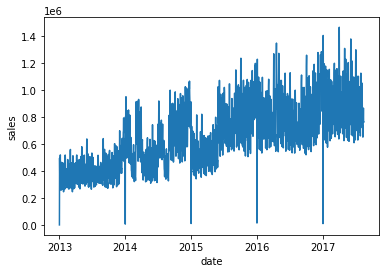

In [97]:
sns.lineplot(data=df_daily_sales,x=df_daily_sales.index,y='sales')

In [ ]:
# series is not stationary seen by increasing mean and variance
# drop in sales each year at one of the holidays

<AxesSubplot:xlabel='date', ylabel='sales'>

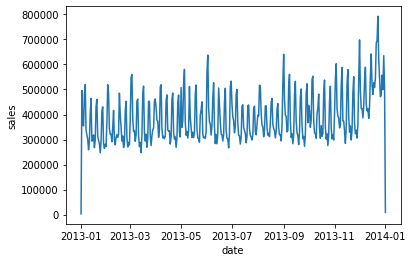

In [93]:
sns.lineplot(data=df_daily_sales[:365],x=df_daily_sales[:365].index,y='sales')

<AxesSubplot:xlabel='date', ylabel='sales'>

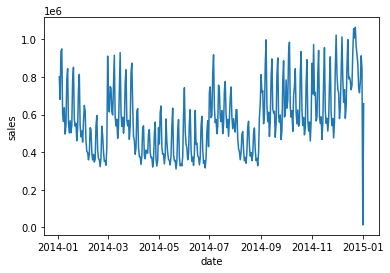

In [95]:
sns.lineplot(data=df_daily_sales[365:730],x=df_daily_sales[365:730].index,y='sales')

<AxesSubplot:xlabel='date', ylabel='sales'>

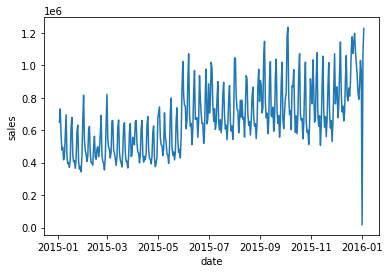

In [96]:
sns.lineplot(data=df_daily_sales[730:1095],x=df_daily_sales[730:1095].index,y='sales')

In [ ]:
# main pattern to predict looks to be weekly or biweekly

<AxesSubplot:xlabel='date', ylabel='sales'>

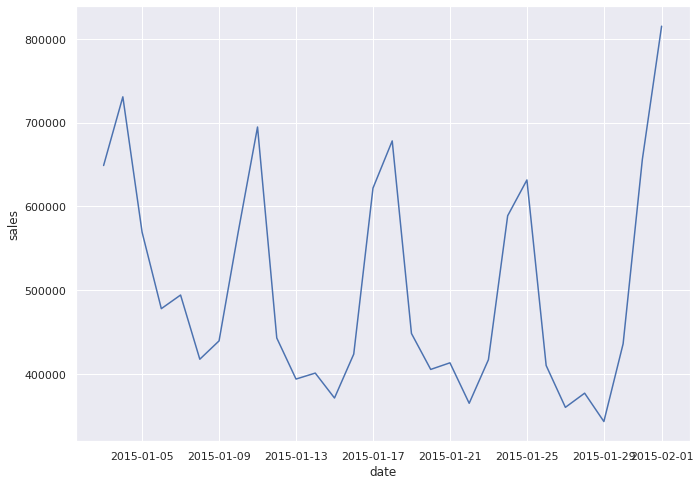

In [9]:
sns.lineplot(data=df_daily_sales[730:760],x=df_daily_sales[730:760].index,y='sales')

In [13]:
# weekly cycle seen where sunday appears to be the peak
df_daily_sales[730:750]

,sales
date,
2015-01-03,"648,880.69"
2015-01-04,"730,923.78"
2015-01-05,"569,267.30"
2015-01-06,"477,886.74"
2015-01-07,"494,160.85"
2015-01-08,"417,482.69"
2015-01-09,"439,381.23"
2015-01-10,"569,956.91"
2015-01-11,"694,860.95"


## (2) Family Level

In [22]:
# get list of unique products
arr_families = df_train['family'].unique()

In [33]:
dict(zip(range(33),arr_families))

{0: 'AUTOMOTIVE',
 1: 'BABY CARE',
 2: 'BEAUTY',
 3: 'BEVERAGES',
 4: 'BOOKS',
 5: 'BREAD/BAKERY',
 6: 'CELEBRATION',
 7: 'CLEANING',
 8: 'DAIRY',
 9: 'DELI',
 10: 'EGGS',
 11: 'FROZEN FOODS',
 12: 'GROCERY I',
 13: 'GROCERY II',
 14: 'HARDWARE',
 15: 'HOME AND KITCHEN I',
 16: 'HOME AND KITCHEN II',
 17: 'HOME APPLIANCES',
 18: 'HOME CARE',
 19: 'LADIESWEAR',
 20: 'LAWN AND GARDEN',
 21: 'LINGERIE',
 22: 'LIQUOR,WINE,BEER',
 23: 'MAGAZINES',
 24: 'MEATS',
 25: 'PERSONAL CARE',
 26: 'PET SUPPLIES',
 27: 'PLAYERS AND ELECTRONICS',
 28: 'POULTRY',
 29: 'PREPARED FOODS',
 30: 'PRODUCE',
 31: 'SCHOOL AND OFFICE SUPPLIES',
 32: 'SEAFOOD'}

In [25]:
# create a list of all daily sales by product family
df_daily_sales_family = []

for i in arr_families:
    
    DataFrame = df_train[df_train['family']==i]
    
    DataFrame = (
                    DataFrame
                    .groupby(by='date').sum()
                    .drop(columns=['id','store_nbr','onpromotion'])
                    .rename(columns={'sales':i})
    )
    
    df_daily_sales_family.append(DataFrame)
    

In [27]:
df_daily_sales_family[0]

,AUTOMOTIVE
date,
2013-01-01,0.00
2013-01-02,255.00
2013-01-03,161.00
2013-01-04,169.00
2013-01-05,342.00
...,...
2017-08-11,441.00
2017-08-12,403.00
2017-08-13,481.00
